# Статистический анализ данных

**Цели исследования:** 
- проанализировать, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании
- проанализировать, можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров
- проверить гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки
- ответить на вопрос, какой тест понадобится для проверки гипотезы, что количество обращений в техподдержку снизилось с момента обновления сервера
- выяснить, какое количество промокодов нужно разослать для того, чтобы определенное количество клиентов продлило подписку
- построить примерный график распределения вероятности открытия уведомлений и оцените вероятность того, что уведомление о откроют не более определенного количества пользователей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from scipy.stats import binom, norm
from math import sqrt
from math import factorial

# Шаг 1. Загрузка данных

In [2]:
#пользователи
users_data= pd.read_csv('users_go.csv')
#поездки
rides_data= pd.read_csv('rides_go.csv')
#Подписки 
subscriptions_data= pd.read_csv('subscriptions_go.csv')

In [3]:
#изучение данных о пользователях
users_data.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


In [4]:
#изучение данных о пользователях -типы
users_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


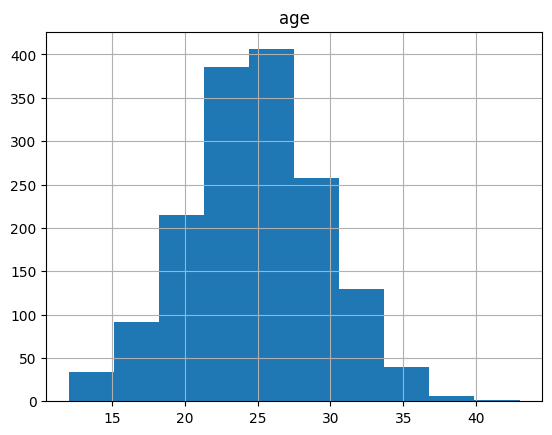

In [5]:
# Построим гистограмму для числовых столбцов таблицы, где это оправдано
users_data.hist('age')
plt.show()

In [6]:
#изучение данных о поездках
rides_data.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


In [7]:
#изучение данных о поездках - типы
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


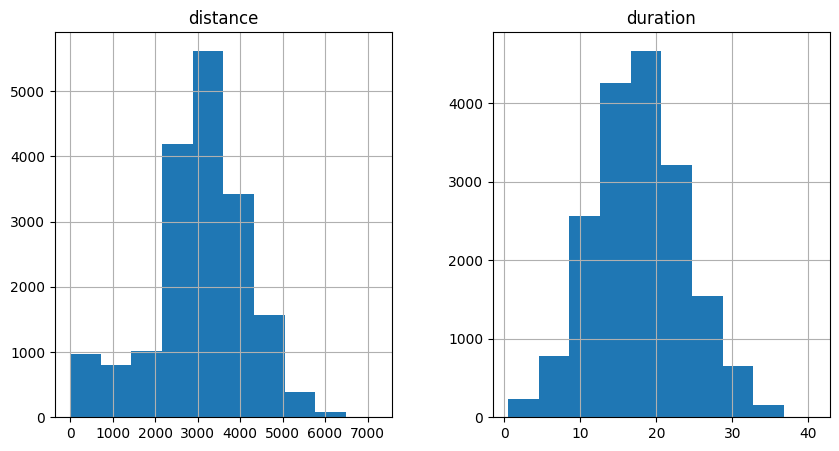

In [8]:
# Построим гистограмму для числовых столбцов таблицы, где это оправдано
rides_data.hist(['distance', 'duration'], figsize=(10, 5))
plt.show()

In [9]:
#изучение данных о подписках
subscriptions_data.head(10)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [10]:
#изучение данных о подписках - типы
subscriptions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Предварительный вывод на данном шаге: данные выглядят "прилично" с точки зрения соответствия типам. По предварительной оценке  пропусков не должно быть (на основе данных "info()" можно видеть, что количество в каждом столбце одинаково, ниже еще проверим данные на пропуски соответвующими методами). Требуется сконвертировать столбец "date" таблицы rides_data к типу даты pandas (что отмечено в задании к проекту).
Числовые данные распределены (судя по гистограммам) близко к нормальному распределению**

# Шаг 2. Предобработка данных

**2.1 Приведем столбец date к типу даты pandas**

In [11]:
rides_data['date']= pd.to_datetime(rides_data['date'], errors='coerce')
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [12]:
#проверим, за какое время наши данные
rides_data['date'].describe(datetime_is_numeric=True)

count                            18068
mean     2021-06-30 19:47:21.266327296
min                2021-01-01 00:00:00
25%                2021-04-02 00:00:00
50%                2021-06-30 00:00:00
75%                2021-09-28 00:00:00
max                2021-12-30 00:00:00
Name: date, dtype: object

**Вывод: данные за 1 год, аналитика по месяцам будет корректной**

**2.2 Создание столбца с номером месяца**

In [13]:
rides_data['month']=rides_data['date'].dt.month
rides_data.head()#выведем для проверки результата

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


**2.3 Проверка пропусков в данных**

In [14]:
#проверим количество пропусков для данных о пользователях
pd.DataFrame(round(users_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
user_id,0.000000
name,0.000000
age,0.000000
city,0.000000
subscription_type,0.000000


In [15]:
#проверим количество пропусков для данных о поездках
pd.DataFrame(round(rides_data.isna().mean()*100,1)).style.background_gradient('coolwarm')

,0
user_id,0.000000
distance,0.000000
duration,0.000000
date,0.000000
month,0.000000


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>☀️
    
Отличный метод, вообще `style` обладает огромным функционалом, который рекомендую использовать [тут](https://habr.com/ru/post/521894/) можно почитать 


</div>

**Вывод по наличию пропусков в данных: не обнаружено**

**2.3 Проверка и обработка дубликатов**

In [16]:
#число явных дубликатов для пользователей
users_data.duplicated().sum()

31

In [17]:
#удаляем явные дубликаты для таблицы с пользователями
users_data= users_data.drop_duplicates()

In [18]:
#контрольная проверка
users_data.duplicated().sum()

0

In [19]:
#число явных дубликатов для данных о поездках
rides_data.duplicated().sum()

0

**Вывод по явным дубликатам: явные дубликаты в таблице описания пользователей удалены. В таблицах описаний поездок и подписок явные дубликаты не обнаружены**

In [20]:
#сортированный список для поиска неявных дубликатов для наименований городов
sorted(users_data.city.unique())

['Екатеринбург',
 'Краснодар',
 'Москва',
 'Омск',
 'Пятигорск',
 'Ростов-на-Дону',
 'Сочи',
 'Тюмень']

**Вывод: неявных дубликатов не обнаружено**

# Шаг 3. Исследовательский анализ данных

**3.1 Частота встречаемости городов**

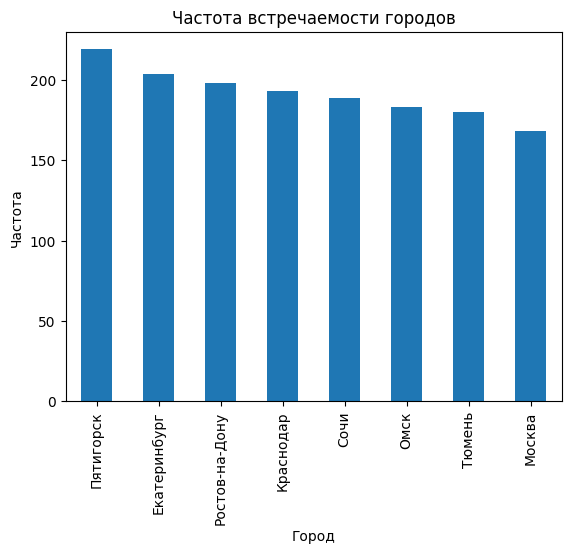

In [21]:
users_data.loc[:,"city"].value_counts().plot(
kind='bar',
xlabel='Город',
ylabel='Частота',
title='Частота встречаемости городов')
plt.show()

In [22]:
users_data.loc[:,"city"].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

In [23]:
#оценим размах
100*(users_data.loc[:,"city"].value_counts().max()- users_data.loc[:,"city"].value_counts().min())/users_data.loc[:,"city"].value_counts().max()


23.28767123287671

**Вывод: в лидерах Пятигорск, наименее часто встречается как ни странно Москва с отставанием в 23%.** 

**3.2 Соотношение пользователей с подпиской и без**

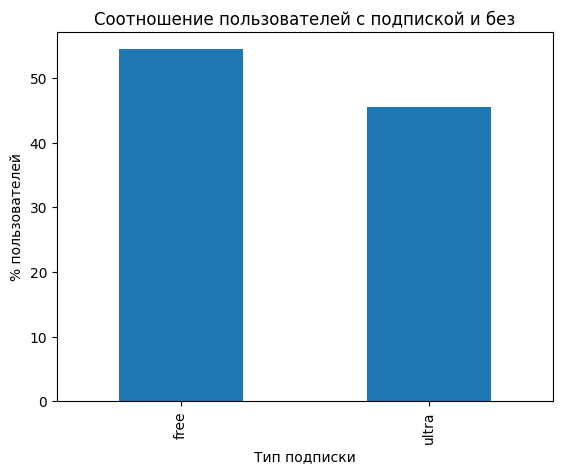

In [24]:
#скорее всего нам интересно именно соотношение в %, а не абсолютная величина
(users_data["subscription_type"].value_counts()/len(users_data)*100).plot(
kind='bar',
xlabel='Тип подписки',
ylabel='% пользователей',
title='Соотношение пользователей с подпиской и без')
plt.show()

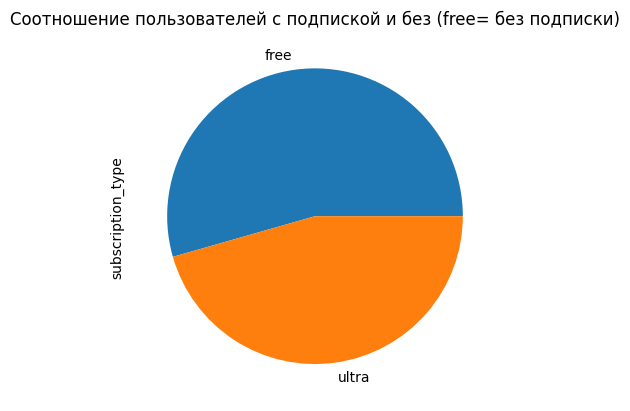

In [25]:
(users_data["subscription_type"].value_counts()/len(users_data)*100).plot(
kind='pie',
xlabel='Тип подписки',
title='Соотношение пользователей с подпиской и без (free= без подписки)')
plt.show()

**Вывод: пользователей без подписки чуть больше (54% и 46% соответственно)**

**3.3 Возраст пользователей**

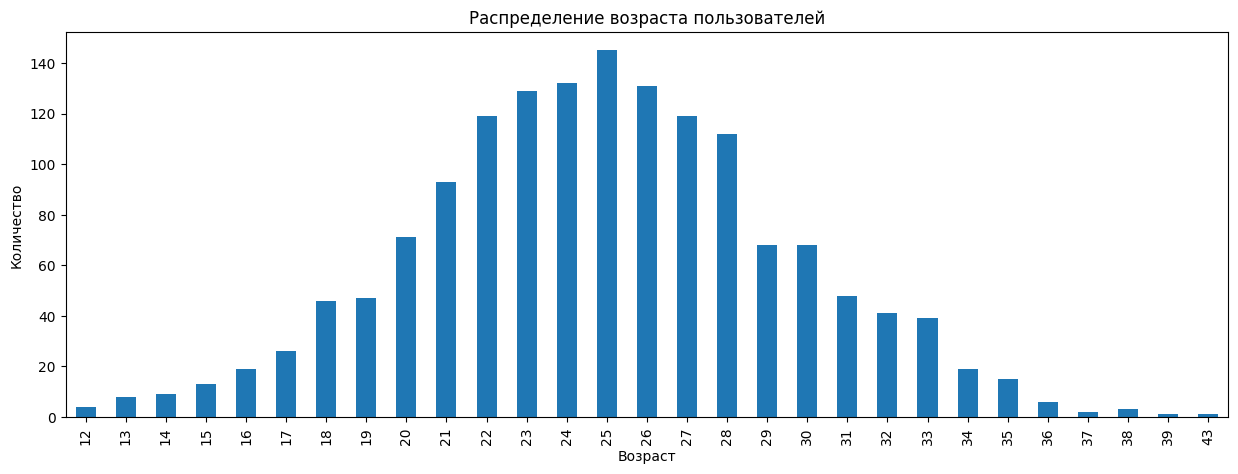

In [26]:
users_data.loc[:,"age"].value_counts(sort = False).plot(
figsize=(15,5),
kind='bar',
xlabel='Возраст',
ylabel='Количество',
title='Распределение возраста пользователей')
plt.show()

In [27]:
#получим статистические данные
users_data['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

**Вывод: средний возраст пользователей чуть меньше 25 лет, минимальный - 12 лет, максимальный - 43 года. Вид распределения близок к нормальному (значения симметрично распределены вокруг среднего)**

**3.4 Расстояние, которое пользователь преодолел за одну поездку**

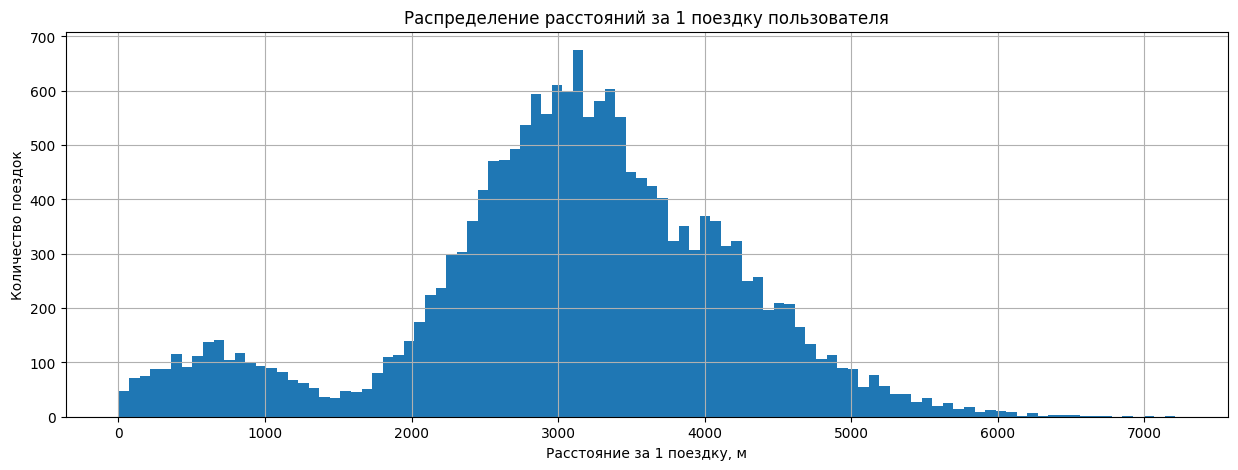

In [28]:
#построим гистограмму
rides_data['distance'].hist(bins=100, figsize=(15,5))
plt.xlabel('Расстояние за 1 поездку, м')
plt.ylabel('Количество поездок')
plt.title('Распределение расстояний за 1 поездку пользователя')
plt.show()

In [29]:
#оценим характеристики распределения
rides_data['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

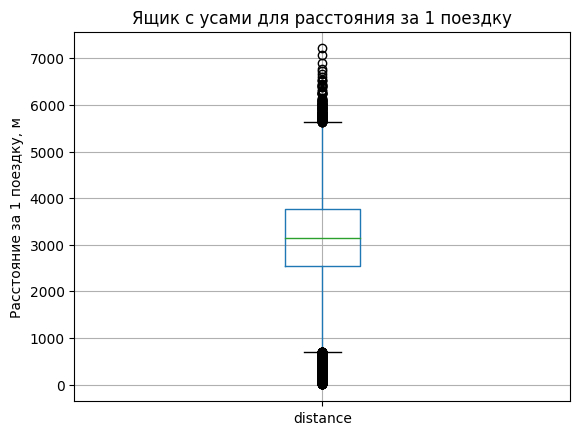

In [30]:
#ящик с усами на предмет выбросов
rides_data.boxplot(column='distance')
plt.ylabel('Расстояние за 1 поездку, м')
plt.title('Ящик с усами для расстояния за 1 поездку')
plt.show()

In [31]:
#вычислим, сколько аномальных значений за пределами верхней границы усов
quartiles = rides_data['distance'].quantile([0.25, 0.75])
iqr = quartiles[0.75] - quartiles[0.25]
upper_level=quartiles[0.75] + 1.5*iqr
display(upper_level)
anoma_values_cnt=rides_data[rides_data['distance']>upper_level]['distance'].count()
100*anoma_values_cnt/len(rides_data)#значение в % от общего объема выборки

5625.717298360568

0.6973655080805845

In [32]:
#вычислим, сколько аномальных значений за пределами нижней границы усов
lower_level=quartiles[0.25] - 1.5*iqr
display(lower_level)
anoma_values_cnt=rides_data[rides_data['distance']<lower_level]['distance'].count()
100*anoma_values_cnt/len(rides_data)#значение в % от общего объема выборки

693.7317969370258

5.036528669470888

**Вывод: пользователи за одну поездку проезжают в среднем 3 км, при этом распределение 95% расстояний за 1 поездку симметрично распределено относительно среднего, при этом ~5% поездок совершаются на короткие дистанции менее 693 метров и менее 1% поездок на дистанции более 5625 метров**

**3.5 Продолжительность поездок**

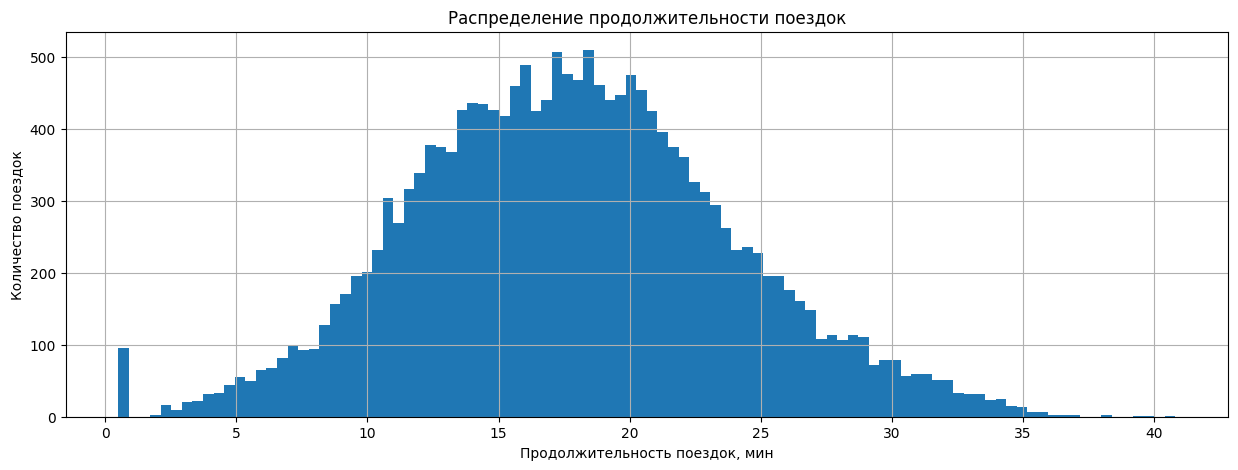

In [33]:
#построим гистограмму
rides_data['duration'].hist(bins=100, figsize=(15,5))
plt.xlabel('Продолжительность поездок, мин')
plt.ylabel('Количество поездок')
plt.title('Распределение продолжительности поездок')
plt.show()

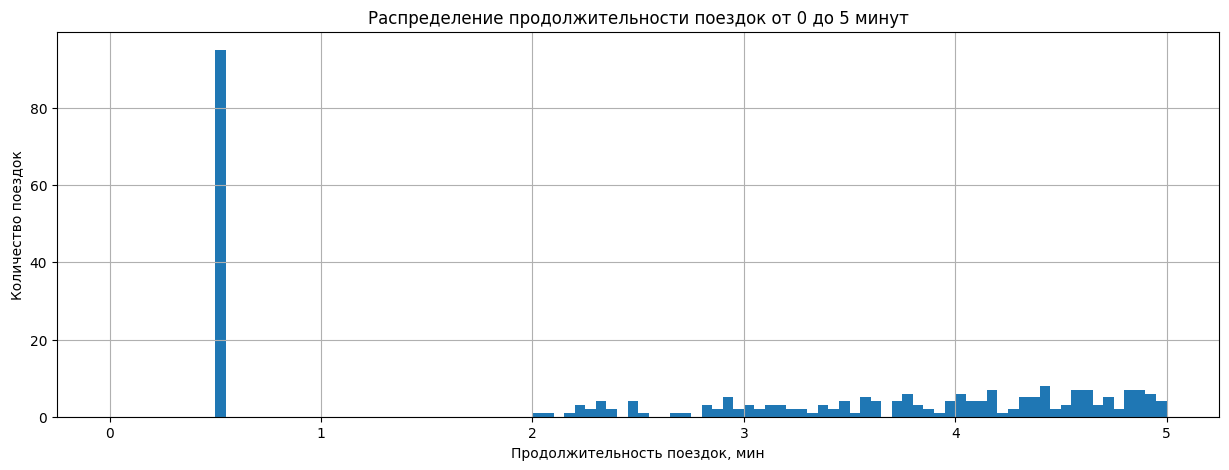

In [34]:
#построим гистограмму для диапазона с предположительным выбросом
rides_data['duration'].hist(bins=100, figsize=(15,5), range=(0,5))
plt.xlabel('Продолжительность поездок, мин')
plt.ylabel('Количество поездок')
plt.title('Распределение продолжительности поездок от 0 до 5 минут')
plt.show()

In [35]:
#оценим % поездок в районе 30 сек
100*rides_data[rides_data['duration']<1]['duration'].count()/rides_data['duration'].count()

0.5257914545052026

In [36]:
#оценим характеристики распределения
rides_data['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

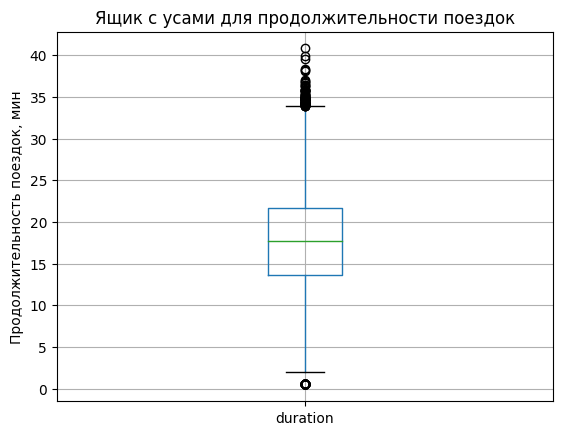

In [37]:
#ящик с усами на предмет выбросов
rides_data.boxplot(column='duration')
plt.ylabel('Продолжительность поездок, мин')
plt.title('Ящик с усами для продолжительности поездок')
plt.show()

In [38]:
#вычислим, сколько аномальных значений за пределами верхней границы усов
quartiles = rides_data['duration'].quantile([0.25, 0.75])
iqr = quartiles[0.75] - quartiles[0.25]
upper_level=quartiles[0.75] + 1.5*iqr
display(upper_level)
anoma_values_cnt=rides_data[rides_data['duration']>upper_level]['duration'].count()
100*anoma_values_cnt/len(rides_data)#значение в % от общего объема выборки

33.91565577561293

0.45384104494133276

In [39]:
#вычислим, сколько аномальных значений за пределами нижней границы усов
lower_level=quartiles[0.25] - 1.5*iqr
display(lower_level)
anoma_values_cnt=rides_data[rides_data['duration']<lower_level]['duration'].count()
100*anoma_values_cnt/len(rides_data)#значение в % от общего объема выборки

1.4067070934272756

0.5257914545052026

**Вывод: поездка в среднем длится примерно 17 минут, длительность при этом распределена симметрично относительно среднего значения. Максиммальное время поездки 40 минут, минимальное 30 секунд. Доля поездок длительностью ровно 30 секунд составляет 0,5% - можно предположить, что это поездки, в которых пользователь передумал ехать, либо эти данные получены в результате сбоя ПО для сбора данных. Доля поездок длительностью более 33 минут составляет менее 0,5%.**

# Шаг 4. Объединение данных

**4.1 Объединение данных о пользователях, поездках и подписках в один датафрейм**

In [40]:
#объединим данные о пользователях и поездках
print(f"Размер данных о пользователях до объединения таблиц:{len(users_data)}")
print(f"Размер данных о поездках до объединения таблиц:{len(rides_data)}")
user_rides_data= users_data.merge(rides_data, on='user_id')
user_rides_data.head()

Размер данных о пользователях до объединения таблиц:1534
Размер данных о поездках до объединения таблиц:18068


,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


In [41]:
#проверка, что после соединения таблиц размер объединенной таблице соответствует ожиданиям
print(f"Размер данных объединенной таблицы:{len(user_rides_data)}")

Размер данных объединенной таблицы:18068


In [42]:
#контроль пропусков в данных (может есть пользователь без единой поездки?)
user_rides_data.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
distance             0
duration             0
date                 0
month                0
dtype: int64

**Размер объединенной таблицы не превышает размера большей до объединения, пропусков в данных не появилось**

In [43]:
#объединим данные о пользователях и поездках и о подписках
user_rides_data= user_rides_data.merge(subscriptions_data, on='subscription_type')
user_rides_data.head(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [44]:
user_rides_data.tail(5)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
18063,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
18064,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
18065,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
18066,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0
18067,1534,Альберт,25,Краснодар,free,2371.711192,15.893917,2021-12-29,12,8,50,0


**4.2 Создание ещё двух датафреймов из датафрейма, созданного на этапе 4.1**

In [45]:
#данные о пользователях без подписки
user_rides_data_ws= user_rides_data[user_rides_data['subscription_type']=='free']
user_rides_data_ws.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [46]:
#данные о пользователях c подпиской
user_rides_data_subscr= user_rides_data[user_rides_data['subscription_type']=='ultra']
user_rides_data_subscr.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


**4.3 Визуализация информации о расстоянии и времени поездок**

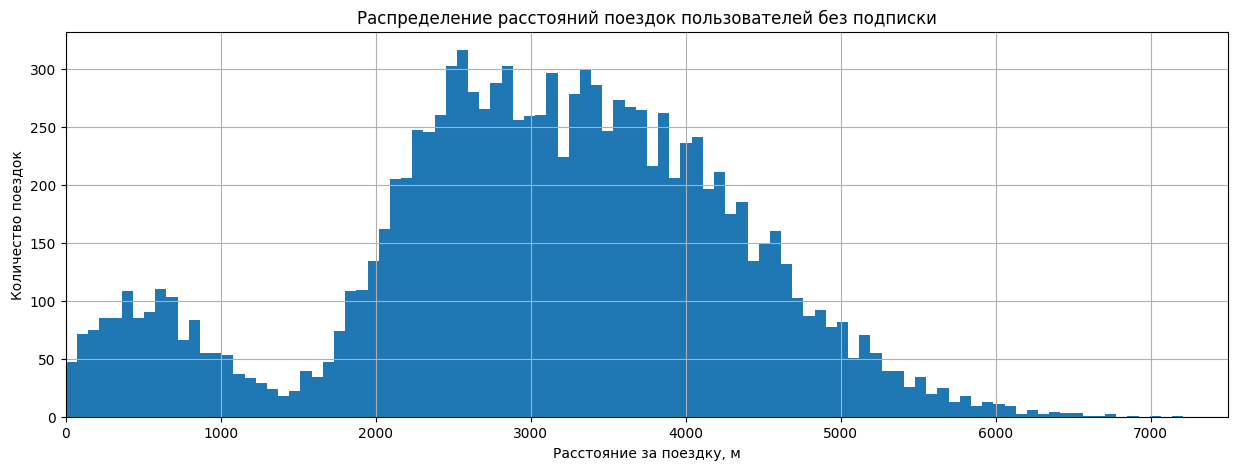

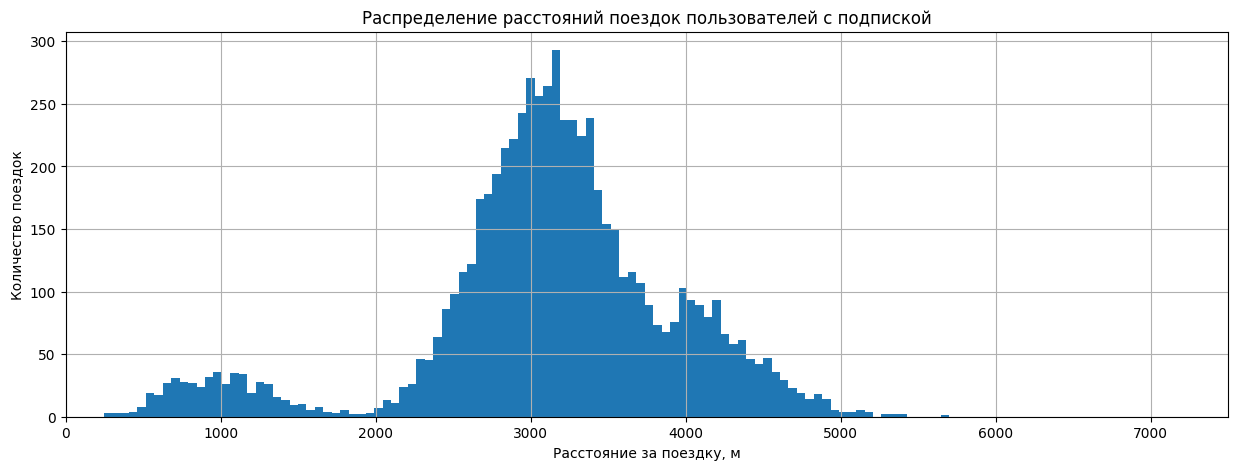

In [47]:
#визуализация информации о расстоянии для пользователей без подписки
plt.figure(1)
user_rides_data_ws['distance'].hist(bins=100, figsize=(15,5))
plt.xlim(xmin=0)
plt.xlim(xmax=7500)
plt.xlabel('Расстояние за поездку, м')
plt.ylabel('Количество поездок')
plt.title('Распределение расстояний поездок пользователей без подписки')

plt.figure(2)
user_rides_data_subscr['distance'].hist(bins=100, figsize=(15,5))
plt.xlim(xmin=0)
plt.xlim(xmax=7500)
plt.xlabel('Расстояние за поездку, м')
plt.ylabel('Количество поездок')
plt.title('Распределение расстояний поездок пользователей с подпиской')
plt.show()

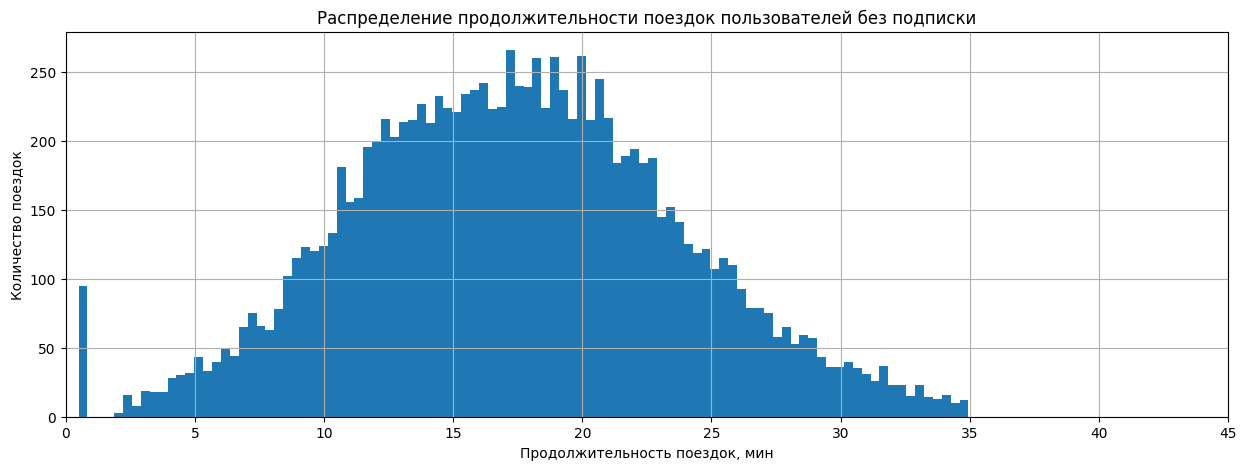

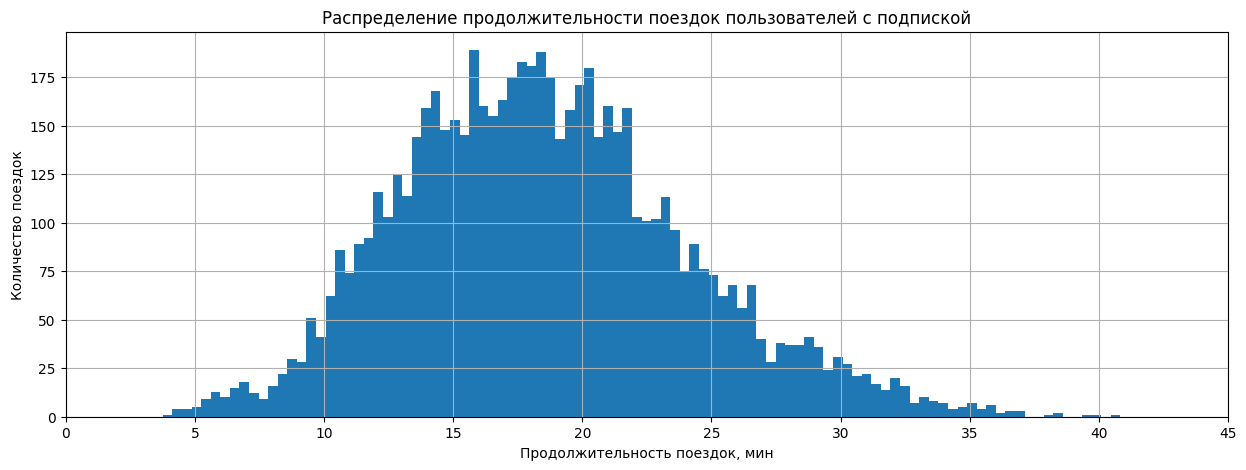

In [48]:
#визуализация информации о продолжительности для пользователей без подписки
plt.figure(1)
user_rides_data_ws['duration'].hist(bins=100, figsize=(15,5))
plt.xlabel('Продолжительность поездок, мин')
plt.ylabel('Количество поездок')
plt.xlim(xmin=0)
plt.xlim(xmax=45)
plt.title('Распределение продолжительности поездок пользователей без подписки')
#визуализация информации о продолжительности для пользователей c подпиской
plt.figure(2)
user_rides_data_subscr['duration'].hist(bins=100, figsize=(15,5))
plt.xlabel('Продолжительность поездок, мин')
plt.ylabel('Количество поездок')
plt.xlim(xmin=0)
plt.xlim(xmax=45)
plt.title('Распределение продолжительности поездок пользователей с подпиской')

plt.show()

In [49]:
#показатели распредления расстояния для пользователей с подпиской
user_rides_data_ws['distance'].describe()

count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64

In [50]:
#показатели распредления расстояния для пользователей с подпиской
user_rides_data_subscr['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

In [51]:
#показатели распредления длительности для пользователей с подпиской
user_rides_data_ws['duration'].describe()

count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64

In [52]:
#показатели распредления длительности для пользователей с подпиской
user_rides_data_subscr['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

**Вывод: распределение длительности и расстояния для пользователей с подпиской имеет меньшую дисперсию. Средние значения тоже немного выше у пользователей с подпиской, видимо за счет экономии в стоимости за 1 минуту** 

# Шаг 5. Подсчёт выручки

**5.1 Датафрейм с агрегированными данными о поездках**

In [53]:
#Датафрейм с агрегированными данными 
user_rides_data_aggr=user_rides_data.pivot_table(index=['user_id','month'], values=['distance','duration'], aggfunc=['sum','count'])
user_rides_data_aggr.columns=['distance','duration','count', 'count2']
user_rides_data_aggr= user_rides_data_aggr.drop(columns='count2')
user_rides_data_aggr.head(10)

distance   duration  count
user_id month                                
1       1       7027.511294  41.416640      2
        4        754.159807   6.232113      1
        8       6723.470560  44.776802      2
        10      5809.911100  31.578017      2
        11      7003.499363  53.397424      3
        12      6751.629942  27.203912      2
2       3      10187.723006  60.959959      3
        4       6164.381824  39.048633      2
        6       3255.338202  13.851127      1
        7       6780.722964  46.170157      2

In [54]:
#подготовим часть данных по ценам
price_df=user_rides_data.pivot_table(index=['user_id','month'], values=['start_ride_price','minute_price','subscription_fee'], aggfunc='median')
price_df.head()

minute_price  start_ride_price  subscription_fee
user_id month                                                  
1       1                 6                 0               199
        4                 6                 0               199
        8                 6                 0               199
        10                6                 0               199
        11                6                 0               199

In [55]:
#добавляем данные о ценах в агрегированную таблицу
user_rides_data_aggr['minute_price']=price_df['minute_price']
user_rides_data_aggr['start_ride_price']=price_df['start_ride_price']
user_rides_data_aggr['subscription_fee']=price_df['subscription_fee']
user_rides_data_aggr.head(10)

distance   duration  count  minute_price  start_ride_price  \
user_id month                                                                   
1       1       7027.511294  41.416640      2             6                 0   
        4        754.159807   6.232113      1             6                 0   
        8       6723.470560  44.776802      2             6                 0   
        10      5809.911100  31.578017      2             6                 0   
        11      7003.499363  53.397424      3             6                 0   
        12      6751.629942  27.203912      2             6                 0   
2       3      10187.723006  60.959959      3             6                 0   
        4       6164.381824  39.048633      2             6                 0   
        6       3255.338202  13.851127      1             6                 0   
        7       6780.722964  46.170157      2             6                 0   

               subscription_fee  
user_id month                    
1       1                   199  
        4                   199  
        8                   199  
        10                  199  
        11                  199  
        12                  199  
2       3                   199  
        4                   199  
        6                   199  
        7                   199

**5.2 Подсчет выручки**

In [56]:
#округлим продолжительность каждой поездки до целого числа (вверх)
user_rides_data_aggr['duration'] = np.ceil(user_rides_data_aggr['duration']) 
user_rides_data_aggr.head(10)

distance  duration  count  minute_price  start_ride_price  \
user_id month                                                                  
1       1       7027.511294      42.0      2             6                 0   
        4        754.159807       7.0      1             6                 0   
        8       6723.470560      45.0      2             6                 0   
        10      5809.911100      32.0      2             6                 0   
        11      7003.499363      54.0      3             6                 0   
        12      6751.629942      28.0      2             6                 0   
2       3      10187.723006      61.0      3             6                 0   
        4       6164.381824      40.0      2             6                 0   
        6       3255.338202      14.0      1             6                 0   
        7       6780.722964      47.0      2             6                 0   

               subscription_fee  
user_id month                    
1       1                   199  
        4                   199  
        8                   199  
        10                  199  
        11                  199  
        12                  199  
2       3                   199  
        4                   199  
        6                   199  
        7                   199

In [57]:
#проверка значений для пользователей без подписки (в конце таблицы)
user_rides_data_aggr.tail(10)

distance  duration  count  minute_price  start_ride_price  \
user_id month                                                                  
1533    8       4581.943632      22.0      1             8                50   
        11      3414.448028      26.0      1             8                50   
1534    1       4678.415899      16.0      1             8                50   
        2       2103.914120      14.0      1             8                50   
        4       3434.290912      15.0      1             8                50   
        6       3409.468534      25.0      2             8                50   
        8       7622.453034      48.0      2             8                50   
        9       4928.173852      23.0      1             8                50   
        11     13350.015305      77.0      4             8                50   
        12      2371.711192      16.0      1             8                50   

               subscription_fee  
user_id month                    
1533    8                     0  
        11                    0  
1534    1                     0  
        2                     0  
        4                     0  
        6                     0  
        8                     0  
        9                     0  
        11                    0  
        12                    0

In [58]:
#подсчет выручки
user_rides_data_aggr['income']= (
   user_rides_data_aggr['start_ride_price']*user_rides_data_aggr['count']+
   user_rides_data_aggr['minute_price']*user_rides_data_aggr['duration']+
   user_rides_data_aggr['subscription_fee']
)
user_rides_data_aggr.head(10)

distance  duration  count  minute_price  start_ride_price  \
user_id month                                                                  
1       1       7027.511294      42.0      2             6                 0   
        4        754.159807       7.0      1             6                 0   
        8       6723.470560      45.0      2             6                 0   
        10      5809.911100      32.0      2             6                 0   
        11      7003.499363      54.0      3             6                 0   
        12      6751.629942      28.0      2             6                 0   
2       3      10187.723006      61.0      3             6                 0   
        4       6164.381824      40.0      2             6                 0   
        6       3255.338202      14.0      1             6                 0   
        7       6780.722964      47.0      2             6                 0   

               subscription_fee  income  
user_id month                            
1       1                   199   451.0  
        4                   199   241.0  
        8                   199   469.0  
        10                  199   391.0  
        11                  199   523.0  
        12                  199   367.0  
2       3                   199   565.0  
        4                   199   439.0  
        6                   199   283.0  
        7                   199   481.0

**Вывод: подсчитанная помесячная выручка на каждого пользователя в столбце "income" таблицы "user_rides_data_aggr"**

# Шаг 6. Проверка гипотез

**6.1 Проверка гипотезы, тратят ли пользователи с подпиской больше времени на поездки**

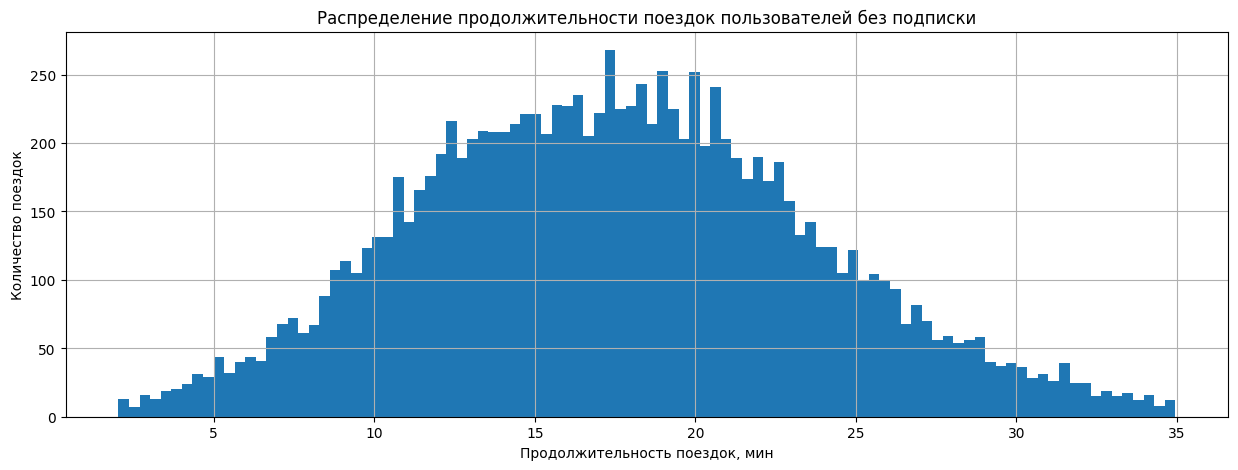

In [59]:
#проверим гипотезу H0, что средние двух генеральных совокупностей (длительности поездок без подписки и с подпиской) равны
#альтернативная гипотеза H1 - что среднее генеральной совокупности длительности без подписки меньше среднего с подпиской
#(проведем левосторонний t-test)
#для этого отсечем выбросы (поездки равные 30 секунд) для распределения продолжительности для пользователей без подписки 
#(тк есть подозрение, что они неоправданно увеличивают дисперсию)
#отсекаемых данных менее 1%, так что можно сделать это безболезненно
user_rides_data_ws=user_rides_data_ws[user_rides_data_ws['duration']>0.5]
user_rides_data_ws['duration'].hist(bins=100, figsize=(15,5))
plt.xlabel('Продолжительность поездок, мин')
plt.ylabel('Количество поездок')
plt.title('Распределение продолжительности поездок пользователей без подписки')
plt.show()#визуализируем распределение продолжительности без подписки чтобы убедиться

In [60]:
#проведем левосторонний t-test о равенстве средних для выборок длительности поездок без подписки и с подпиской
alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(user_rides_data_ws['duration'], user_rides_data_subscr['duration'], alternative='less', equal_var=False )

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о равенстве средних')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.6162210195310587e-29
Отвергаем нулевую гипотезу о равенстве средних


**Вывод: гипотеза о равенстве средних отвергнута в пользу альтернативной гипотезы, что длительность поездок без подписки меньше, чем длительность поездок с подпиской. Значит можем сделать вывод, что пользователи с подпиской "выгоднее" пользователей без подписки**

**6.2 Проверка гипотезы об оптимальности среднего расстояния поездки для пользователей с подпиской**

In [61]:
#проведем правосторонний t-test для проверки гипотезы, 
#что среднее расстояние за поездку для пользователей с подпиской не превышает 3130 метров
#гипотеза H0 -среднее расстояние за поездку составляет 3130 метров
#гипотеза H1 - среднее расстояние за поездку превышает 3130 метров
distance_value = 3130
alpha = 0.05 # уровень статистической значимости

results = st.ttest_1samp(user_rides_data_subscr['distance'], distance_value, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


**Вывод: гипотеза о среднем расстоянии за поездку, не превышающем 3130 метров, не отвергнута**

**6.3 Проверка гипотезы, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки**

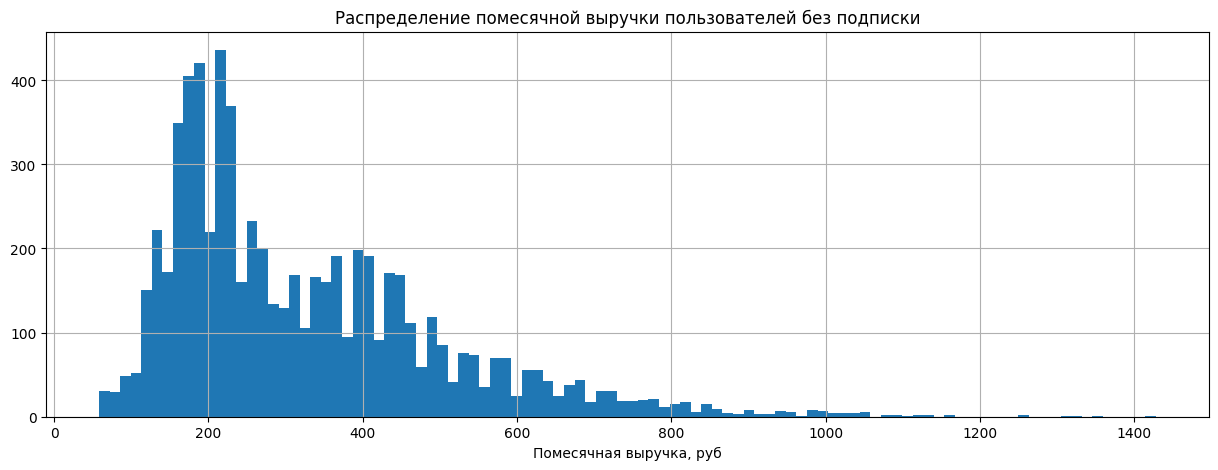

In [62]:
#выделим помесячную выручку от пользователей без подписки 
user_rides_income_ws= user_rides_data_aggr[user_rides_data_aggr['subscription_fee']==0]['income']
user_rides_income_ws.hist(figsize=(15,5), bins=100)
plt.xlabel('Помесячная выручка, руб')
plt.title('Распределение помесячной выручки пользователей без подписки')
plt.show()#визуализируем распределение

In [63]:
#статистика распределения помесячной выручки без подписки
user_rides_income_ws.describe()

count    6798.000000
mean      325.842895
std       180.515646
min        58.000000
25%       194.000000
50%       268.000000
75%       420.000000
max      1428.000000
Name: income, dtype: float64

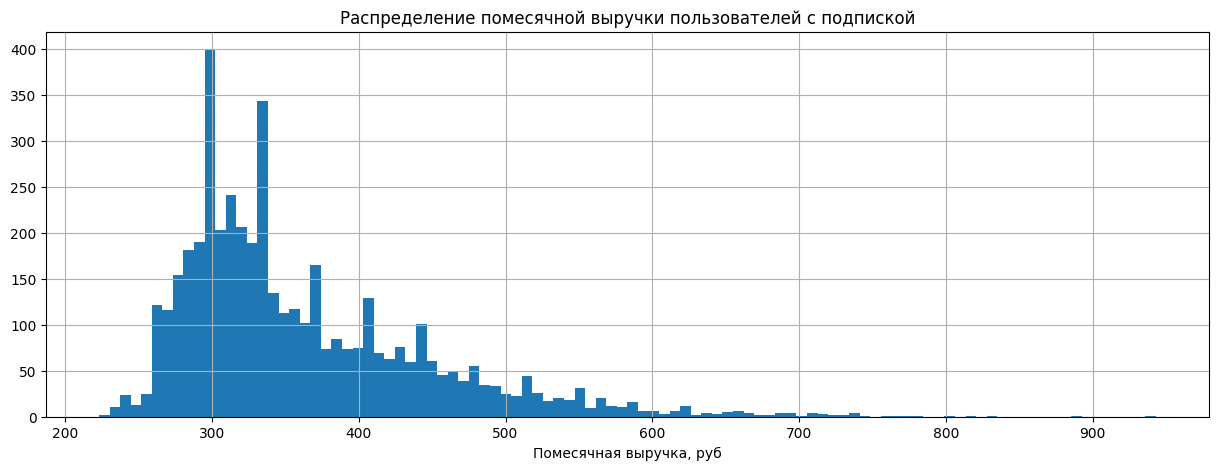

In [64]:
#выделим суммарную помесячную выручку от пользователей с подпиской 
user_rides_income_subscr= user_rides_data_aggr[user_rides_data_aggr['subscription_fee']>0]['income']
user_rides_income_subscr.hist(figsize=(15,5), bins=100)
plt.xlabel('Помесячная выручка, руб')
plt.title('Распределение помесячной выручки пользователей c подпиской')
plt.show()#визуализируем распределение

In [65]:
#статистика распределения помесячной выручки с подпиской
user_rides_income_subscr.describe()

count    4533.000000
mean      361.481800
std        86.399966
min       223.000000
25%       301.000000
50%       331.000000
75%       403.000000
max       943.000000
Name: income, dtype: float64

In [66]:
#проверим гипотезу H0, что средние двух генеральных совокупностей (выручка пользователей без подписки и с подпиской) равны
#альтернативная гипотеза H1 - что среднее генеральной совокупности выручки без подписки меньше среднего с подпиской
#(проведем левосторонний t-test)
alpha = 0.05 # уровень статистической значимости

results = st.ttest_ind(user_rides_income_ws, user_rides_income_subscr, alternative='less', equal_var=False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу о равенстве средних')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.0718729651261336e-44
Отвергаем нулевую гипотезу о равенстве средних


**Вывод: гипотеза о равенстве средней помесячной выручки отвергнута в пользу гипотезы о том, что средняя помесячная выручка от пользователей с подпиской выше.**

**6.4 Ответ на вопрос:"Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?"**

**Ответ:понадобится тест для проверки гипотезы о равенстве среднего генеральной совокупности для зависимых (парных) выборок. В Python реализуется методом scipy.stats.ttest_rel(). Проверять потребуется для двух массивов одинаковой длины. В каждом массиве должны быть заданы с неизменным порядком пары "идентификатор пользователя- количество обращений в техподдержку", в первом массиве до обновления, во втором - после. Гипотеза H0 - что среднее количество обращений осталось неизменным, гипотеза H1 - что оно снизилось (левосторонний тест)** 

# Шаг 7. Распределения

**7.1 Определение минимального количества промокодов**

Вероятность, что будет менее 100 продливших подписку клиентов из получивших 860 промокодов равна 0.05


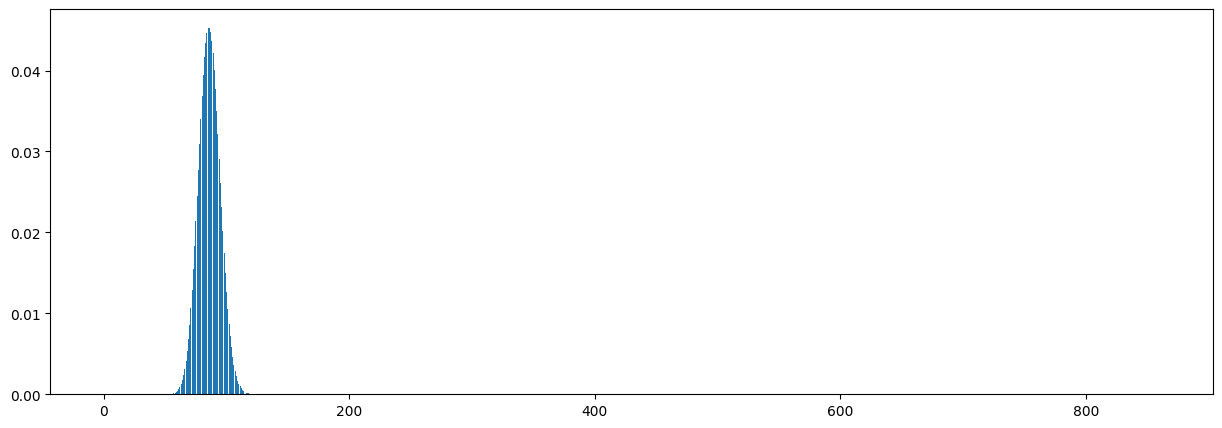

In [67]:
p = 0.1 # вероятность продления подписки
n = 860 # количество промокодов
distr = []

for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1-p)**(n-k) 
    distr.append(prob)
plt.figure(figsize=(15,5))    
plt.bar(range(0, n + 1), distr)

k=100 #клиентов, которые должны продлить подписку для выполнения плана с заданной вероятностью
print(f"Вероятность, что будет менее {k} продливших подписку клиентов из получивших {n} промокодов равна {round(1-binom(n, p).cdf(k),2)}")


**Вывод: требуется как минимум 860 промокодов**

**7.2 Определение оцените вероятность того, что уведомление откроют не более определенного количества пользователей**

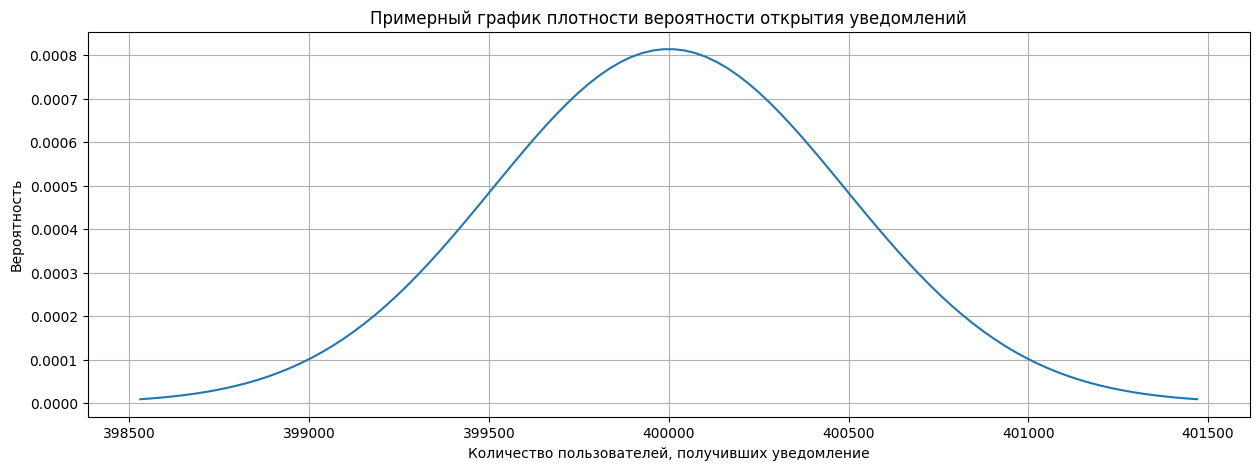

Условие аппроксимации выполняется


In [68]:
# задаём параметры биномиального распределения
n = 1000000
p = 0.4

# зададим параметры нормального распределения равными
# мат.ожиданию и дисперсии биномиального распределения
mu = n * p
sigma = sqrt(n * p * (1 - p))
distr = st.norm(mu, sigma) 
 
# рисуем график нормального распределения:
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.figure(figsize=(15,5))
plt.grid(True)
plt.ylabel('Вероятность')
plt.xlabel('Количество пользователей, получивших уведомление')
plt.title('Примерный график плотности вероятности открытия уведомлений')
plt.plot(x, norm.pdf(x, mu, sigma))
plt.show()

# выводим, выполняется ли наше условие аппроксимации:
# лежит ли mu ± 3 sigma в промежутке от 0 до n:
if (mu - (3 * sigma) >= 0) and ((mu + (3 * sigma) <= n)):
    print('Условие аппроксимации выполняется')
else:
    print('Условие аппроксимации не выполняется')

In [69]:
#оценка вероятности того, что уведомление откроют не более 399,5 тыс. пользователей
distr.cdf(399500)

0.15371708296369768

**Вывод: вероятность того, что уведомление откроют не более 399,5 тыс. пользователей составляет примерно 0,15**

<b><u>Итоговые выводы:</u></b>
    <b>
    <li>
    Пользователи с подпиской тратят больше времени на поездки и проезжают большее расстояние.При этом среднее расстояние, 
    которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров, что близко к оптимальному
    с точки зрения износа самоката. А помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от 
    пользователей без подписки. Учитывая перечисленное, пользователи с подпиской являются выгодными клиентами, 
    более выгодными, чем пользователи без подписки.
    </li>
    <li>
    Для проверки гипотезы, что количество обращений в техподдержку снизилось с момента обновления сервера, понадобится 
    тест для проверки гипотезы о равенстве среднего генеральной совокупности для зависимых (парных) выборок
    </li>
    <li>
    Для того, чтобы как минимум 100 клиентов продлило подписку с 5% вероятностью не выполнить план, нужно минимум 860 промокодов
    </li>
    <li>
    Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, составляет примерно 0,15
    </li>
    </b>